Ce notebook contient l'esemble des essais que j'ai fais pour résoudre le challenge de data camp.

<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup 

If marked as `code`, the two following cells will 

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from problem import get_train_data, get_test_data
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

The Data

In [3]:

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [4]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### A first look at the data


In [5]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

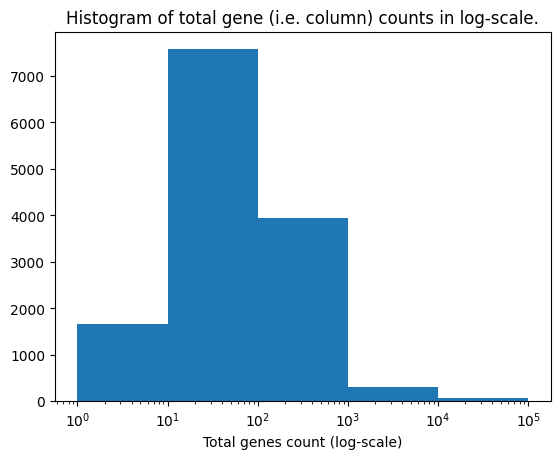

In [6]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

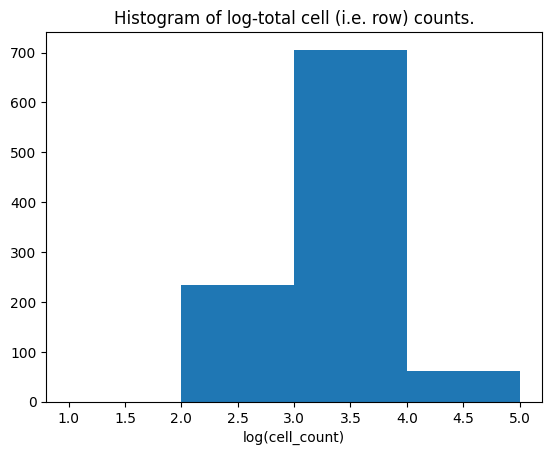

In [7]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

In [8]:
# Convert to DataFrame
x_train = pd.DataFrame(X_train.toarray())
x_test = pd.DataFrame(X_test.toarray())
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,13541,13542,13543,13544,13545,13546,13547,13548,13549,13550
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
classes = y_train.categories
print(classes)
annotation ={} 
for i, cls in enumerate(classes):
    annotation[i] = cls
print(annotation)

Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object')
{0: 'Cancer_cells', 1: 'NK_cells', 2: 'T_cells_CD4+', 3: 'T_cells_CD8+'}


0. Cancer_cells
1. NK_cells
2. T_cells_CD4+
3. T_cells_CD8+


In [10]:
# Annotation des classes
y_train_encoded = y_train.codes
y_test_encoded = y_test.codes
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

y_train.head()

0    2
1    2
2    2
3    2
4    3
dtype: int8

{'classes': Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object'), 'occurrences': 3    342
2    336
0    237
1     85
Name: count, dtype: int64}


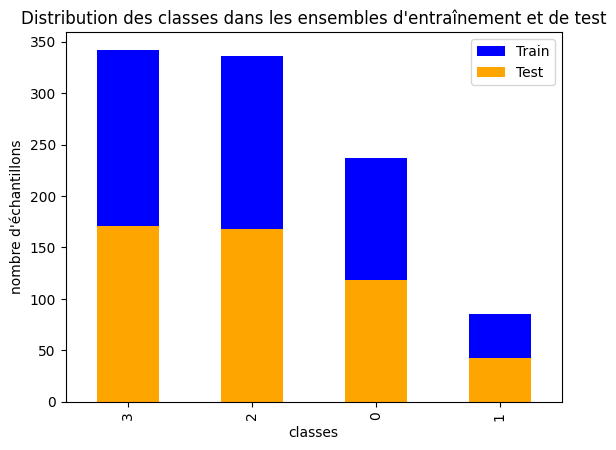

In [11]:
# Exploration des données

## Distribution des classes 
Occurence_train = {}
Occurence_train["classes"] = classes
Occurence_train["occurrences"] = y_train.value_counts()
print(Occurence_train)

y_train.value_counts().plot(kind='bar', color='blue')
y_test.value_counts().plot(kind='bar', color='orange')
plt.xlabel('classes')
plt.ylabel('nombre d\'échantillons')
plt.title('Distribution des classes dans les ensembles d\'entraînement et de test')
plt.legend(['Train','Test'])


Mon premier essai était d'explorer les données et d'essayer de savoir les gènes importantes pour chaque cellule. Le problème c'est que j'ai fait l'exploration sans normalization et jugé que la moitié des gènes ne sont pas assez représentatives pour la majorité des cellules. Les résultats sont dans les diagrammes au-dessous. 
L'idée derrière est aussi le fait d'ajouter des données pour les la classes 1 en se basant sur la distribution de chaque gène dans les cellules détectées cell_1. 

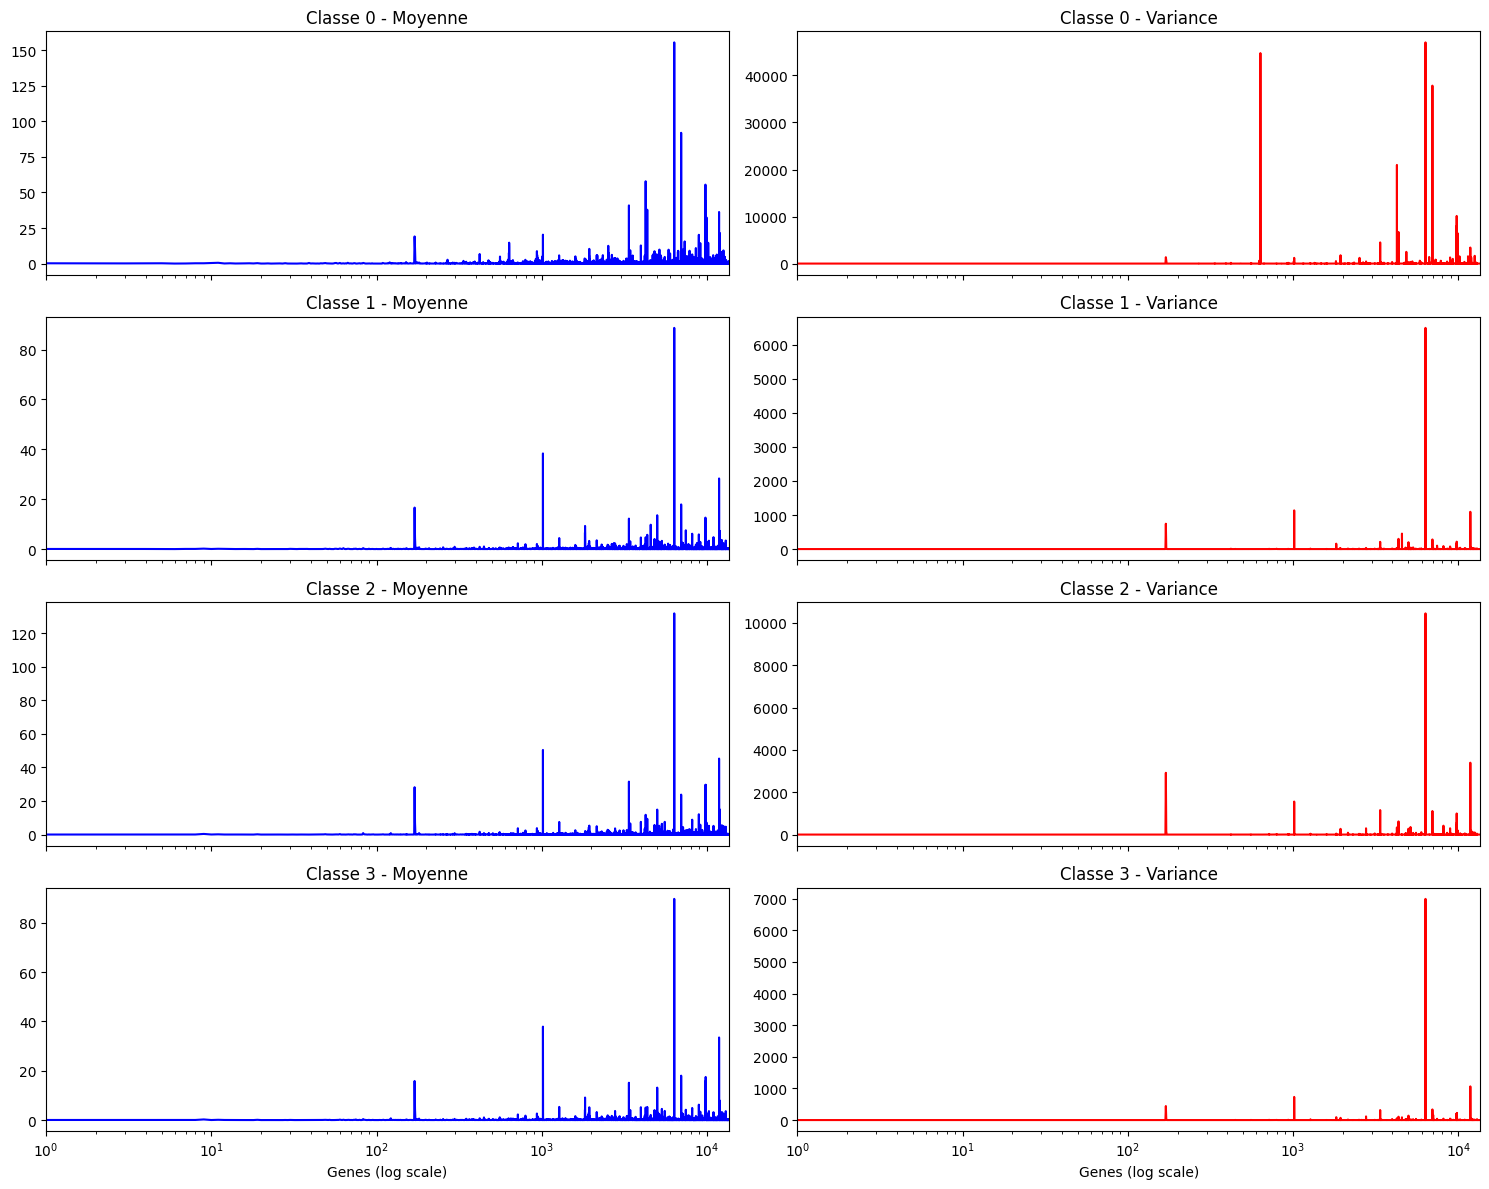

In [12]:
classes = np.unique(y_train)
n_classes = len(classes)
n_genes = X_train.shape[1]

fig, axes = plt.subplots(n_classes, 2, figsize=(15, 3*n_classes), sharex=True)

for idx, cls in enumerate(classes):
    gene_values = X_train[y_train == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convertir sparse -> dense si nécessaire
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    # Moyenne et variance par gène
    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    # Plot moyenne
    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes])

    # Plot variance
    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes])

# Label commun pour l'axe des x
for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()


A partir des digrammes précedants, on remarque qu'environ la moitié  des gènes ( de 0 à 10^2) ne sont pas assez représntatives pour toutes les classes. 
Nous procédons à la suppression des gènes les moins representatifs

In [13]:
import numpy as np
from scipy.sparse import issparse

def remove_genes(X, threshold=0.2):
    """
    Supprime les gènes dont la variance est inférieure à un seuil.

    Args:
        X (np.ndarray ou csr_matrix): matrice cellules x gènes
        threshold (float): seuil minimal de variance

    Returns:
        X_filtered: matrice filtrée (mêmes type que X)
        kept_idx: indices des gènes conservés
    """
    if issparse(X):
        # variance = mean(x^2) - mean(x)^2
        mean = np.array(X.mean(axis=0)).ravel()
        mean_sq = np.array(X.multiply(X).mean(axis=0)).ravel()
        var = mean_sq - mean**2
    else:
        var = X.var(axis=0)

    # indices des gènes à garder
    kept_idx = np.where(var >= threshold)[0]

    # filtrer X
    if issparse(X):
        X_filtered = X[:, kept_idx]
    else:
        X_filtered = X[:, kept_idx]

    return X_filtered, kept_idx
X_train, kept_genes_idx = remove_genes(X_train, threshold=0.01)

**Normalisation**
Maintenant je vais essayer de normaliser les données de x_train et les nommer x_train_normalized.

La question qui se pose: pourquoi appliquer une normalisation ? 
 
 - *Correction de la profondeur de séquençage* : Chaque échantillon peut avoir un nombre total de lectures très différent. Sans normalisation, les différences reflètent surtout la quantité totale de séquençage et non l’expression réelle.
 - *Stabilisation de la variance* : Les gènes peu exprimés ont une variance très élevée relative à leur moyenne. Les gènes très exprimés dominent les analyses multivariées (PCA, clustering).
 - *Comparabilité entre échantillons* : Permet de comparer les niveaux d’expression entre échantillons et conditions.

 


In [14]:
import numpy as np



def preprocess_X(X, method=None):
    """
    Preprocess an RNA-seq expression matrix.
    
    Parameters
    ----------
    X : np.ndarray or scipy.sparse matrix
        Input expression matrix (cells x genes)
    method : str or None
        Type of normalization:
        - None : return X as is
        - "log" : log1p transform
        - "library_size" : normalize each cell by total counts (library size) then log1p
    
    Returns
    -------
    X_processed : np.ndarray
        Preprocessed expression matrix
    """
    # Convert sparse to dense if needed
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    X_processed = X.copy()
    
    if method is None:
        return X_processed
    
    if method == "simple_normalize":
        return X / X.sum(axis=1)[:, np.newaxis]
    
    elif method == "log":
        X_processed = np.log1p(X_processed)
        return X_processed
    
    elif method == "library_size":
        # compute total counts per cell
        library_size = X_processed.sum(axis=1)[:, None]
        # avoid division by zero
        library_size[library_size == 0] = 1
        # normalize
        X_processed = X_processed / library_size * 1e4
        # log1p transform
        X_processed = np.log1p(X_processed)
        return X_processed
    
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

preprocessing_method = "library_size"
X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)


Niveau d'expression des gènes

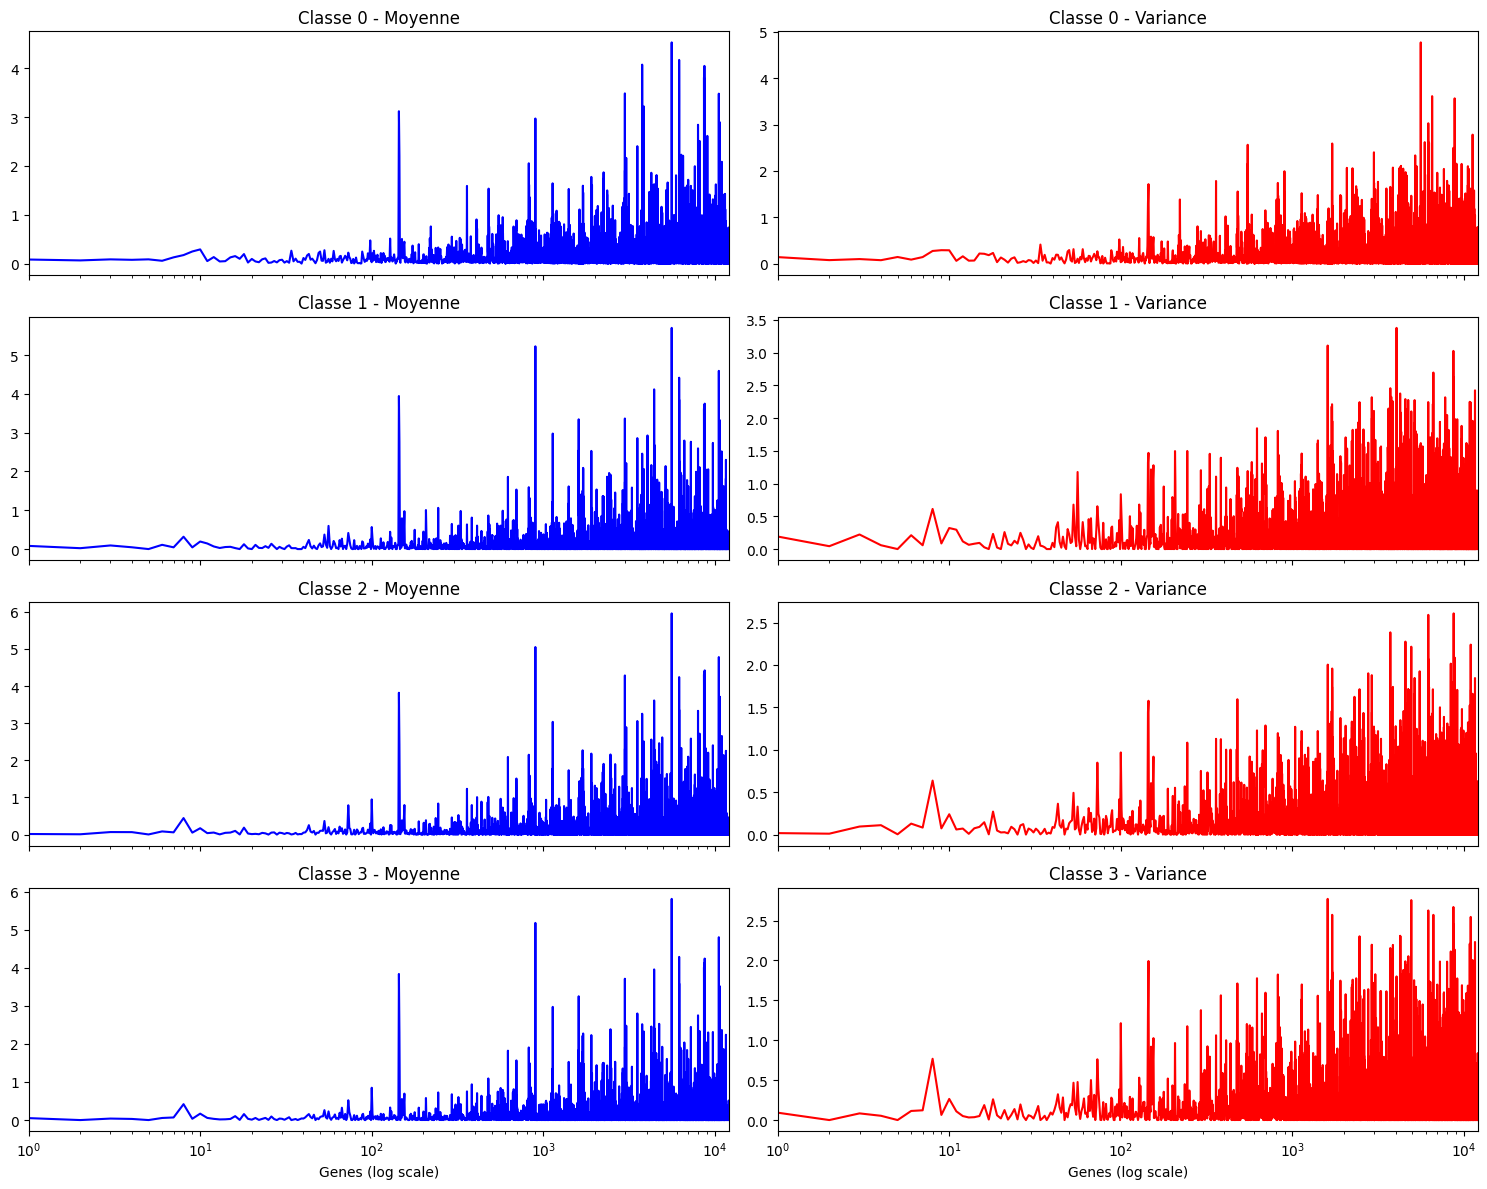

In [15]:
import numpy as np

import matplotlib.pyplot as plt

# Assuming X_train_norm and y_train are available from previous cells
classes = np.unique(y_train)
n_classes = len(classes)
n_genes = X_train_norm.shape[1]

fig, axes = plt.subplots(n_classes, 2, figsize=(15, 3*n_classes), sharex=True)

for idx, cls in enumerate(classes):
    gene_values = X_train_norm[y_train == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convertir sparse -> dense si nécessaire
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    # Moyenne et variance par gène
    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    # Plot moyenne
    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes])

    # Plot variance
    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes])

# Label commun pour l'axe des x
for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()

# ACP

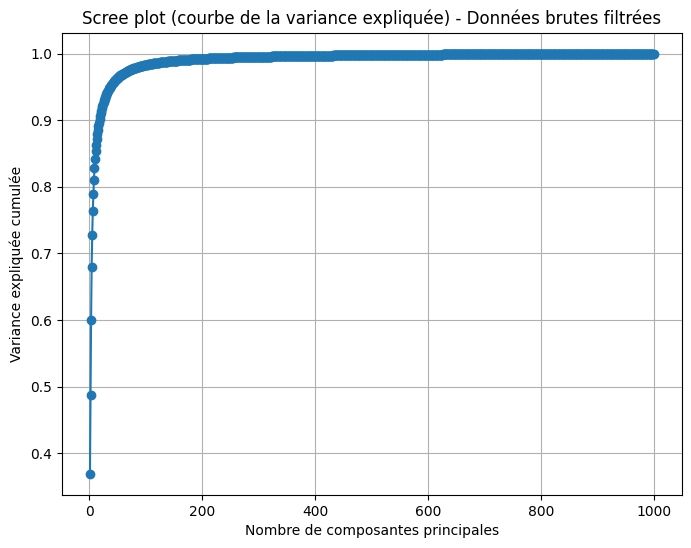

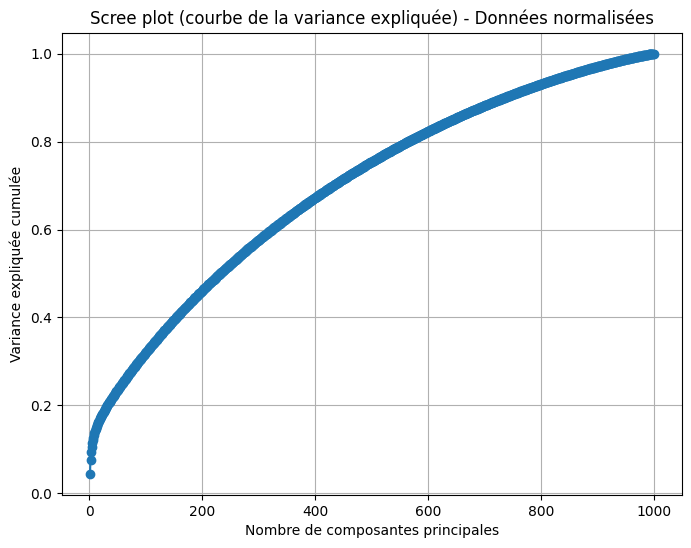

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_scree_plot(X, title_suffix=""):
    """
    Plot the scree plot for PCA on the given data matrix X.
    
    Parameters
    ----------
    X : array-like
        Input data matrix
    title_suffix : str
        Suffix to add to the plot title
    """
    pca = PCA().fit(X)
    explained_variance_cumsum = pca.explained_variance_ratio_.cumsum()
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance_cumsum) + 1), 
             explained_variance_cumsum, marker='o', linestyle='-')
    plt.xlabel('Nombre de composantes principales')
    plt.ylabel('Variance expliquée cumulée')
    plt.title(f'Scree plot (courbe de la variance expliquée){title_suffix}')
    plt.grid(True)
    plt.show()

# Scree plot for raw filtered data
plot_scree_plot(X_train, " - Données brutes filtrées")

# Scree plot for normalized data
plot_scree_plot(X_train_norm, " - Données normalisées")

# Implémentation des models

##  0. Constitution du jeu de test


In [17]:
X_test = X_test[:, kept_genes_idx]
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

## 1. Random Forest

In [18]:



random_forest_pipe = Pipeline(
    [
        #("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 60 components", PCA(n_components=60)),
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=75, n_estimators=200, max_features=15
            ),
        ),
    ]
)

random_forest_pipe

Pipeline(steps=[('PCA with 60 components', PCA(n_components=60)),
                ('Random Forest Classifier',
                 RandomForestClassifier(max_depth=75, max_features=15,
                                        n_estimators=200))])

In [19]:
# fit on train
pipe = random_forest_pipe
pipe.fit(X_train_norm, y_train)
y_tr_pred_random = pipe.predict(X_train_norm)

# predict on test


y_te_pred_random = pipe.predict(X_test_norm)

Train balanced accuracy : 1.000
Test balanced accuracy : 0.754


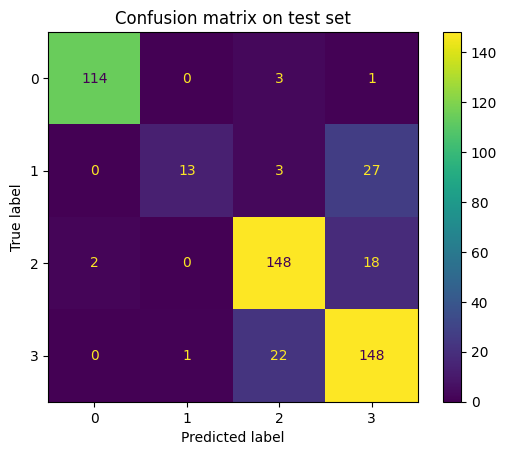

In [20]:


# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred_random):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred_random):.3f}")
cm = confusion_matrix(y_test, y_te_pred_random)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

## 2. LinearSVC

In [21]:


# Create a Linear SVC pipeline
linear_svc_pipe = Pipeline(
    [
        ("PCA", PCA(n_components=60)),
        ("Linear SVC", LinearSVC(max_iter=200000, random_state=42)),
    ]
)
linear_svc_pipe


Pipeline(steps=[('PCA', PCA(n_components=60)),
                ('Linear SVC', LinearSVC(max_iter=200000, random_state=42))])

In [22]:
# fit on train
pipe = linear_svc_pipe
pipe.fit(X_train_norm, y_train)
y_tr_pred_svc = pipe.predict(X_train_norm)

# predict on test


y_te_pred_svc = pipe.predict(X_test_norm)


Train balanced accuracy : 0.898
Test balanced accuracy : 0.799


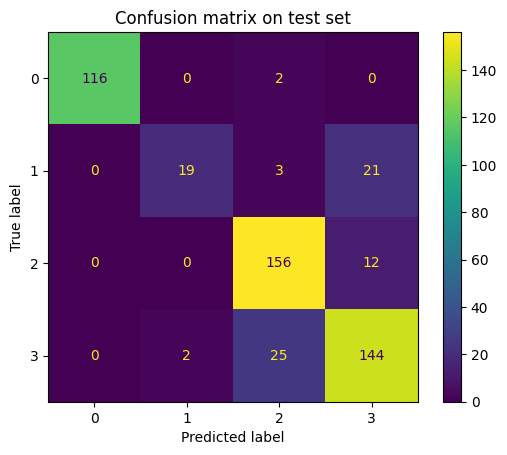

In [23]:
# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred_svc):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred_svc):.3f}")
cm = confusion_matrix(y_test, y_te_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

## KNeighbors classifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Build pipeline: reduce dimensionality then KNN
knn_pipe = Pipeline([
    ("PCA", PCA(n_components=60)),
    ("KNN", KNeighborsClassifier(n_neighbors=20, n_jobs=-1)),
])

knn_pipe

Pipeline(steps=[('PCA', PCA(n_components=60)),
                ('KNN', KNeighborsClassifier(n_jobs=-1, n_neighbors=20))])

Train balanced accuracy : 0.760
Test balanced accuracy : 0.688


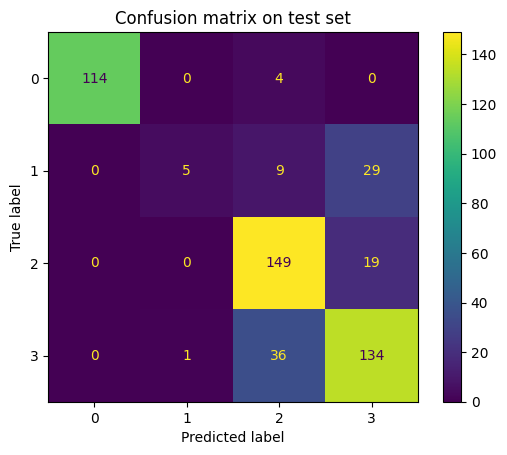

In [25]:
# fit the KNN pipeline
knn_pipe.fit(X_train_norm, y_train)

# compute balanced accuracy and confusion matrix
y_tr_pred_knn = knn_pipe.predict(X_train_norm)
y_te_pred_knn = knn_pipe.predict(X_test_norm)
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred_knn):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred_knn):.3f}")
cm = confusion_matrix(y_test, y_te_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.811


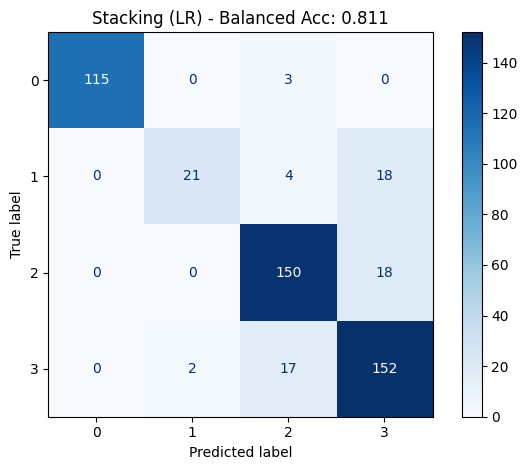

In [26]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensemble classifiers (Voting + Stacking) on PCA-reduced features
# Relies on existing notebook variables: X_train_norm, X_test_norm, y_train, y_test

import matplotlib.pyplot as plt

def fit_eval_ensembles(X_train, X_test, y_train, y_test, pca_n_components=60, random_state=42):
    # encode labels to integers for stacking final estimator
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    # PCA reduction
    pca = PCA(n_components=min(pca_n_components, np.asarray(X_train).shape[1]), random_state=random_state)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # base estimators
    rf = RandomForestClassifier(n_estimators=200, max_depth=50, max_features="sqrt", random_state=random_state)
    svc = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=random_state)
    knn = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)

    # Voting (soft) ensemble
    voting = VotingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
        voting="soft",
        n_jobs=-1,
    )

    # Stacking ensemble (uses same base estimators)
    stacking = StackingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
        final_estimator=LogisticRegression(max_iter=2000, solver="lbfgs"),
        n_jobs=-1,
        passthrough=False,
    )

    ensembles = {
        #"Voting (soft)": voting, 
        "Stacking (LR)": stacking}

    results = {}
    for name, clf in ensembles.items():
        print(f"Fitting {name} ...")
        clf.fit(X_train_pca, y_train_enc)
        y_pred_enc = clf.predict(X_test_pca)
        y_pred = le.inverse_transform(y_pred_enc)
        bal = balanced_accuracy_score(y_test, y_pred)
        results[name] = {"bal_acc": bal, "clf": clf, "y_pred": y_pred}
        print(f"{name} balanced accuracy: {bal:.3f}")

        # confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot(cmap="Blues", values_format='d')
        plt.title(f"{name} - Balanced Acc: {bal:.3f}")
        plt.tight_layout()
        plt.show()

    return results, pca, le

# Run ensembles (uses X_train_norm / X_test_norm already defined in the notebook)
results, pca_model_ens, label_encoder_ens = fit_eval_ensembles(
    X_train_norm, X_test_norm, y_train, y_test, pca_n_components=60
)

# Approche: Prédiction en deux etapes

## Adaptation du dataset, merge des classes 1 et 3

Nous entrainons le modèle sur 3 classes.

In [27]:
#reload the data and preprocess
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [28]:
#normalize the data

X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

X_train_norm_merged = X_train_norm.copy()
X_test_norm_merged = X_test_norm.copy()

# merge classes 1 and 3 (NK_cells and T_cells_CD8+ according to current categories)
merge_from = {"NK_cells", "T_cells_CD8+"}
new_label = "NK_or_T_cells_CD8+"

# convert categorical labels to string arrays and replace
# Use the annotation dict to map codes to names
y_train_arr = np.array([annotation[code] for code in y_train.codes])
y_test_arr = np.array([annotation[code] for code in y_test.codes])

y_train_merged = y_train_arr.copy()
y_train_merged[np.isin(y_train_merged, list(merge_from))] = new_label

y_test_merged = y_test_arr.copy()
y_test_merged[np.isin(y_test_merged, list(merge_from))] = new_label

# convert back to pandas Categorical (keep behavior similar to original y variables)
y_train_merged = pd.Categorical(y_train_merged)
y_test_merged = pd.Categorical(y_test_merged)

# quick check
print("Train label distribution:\n", pd.Series(y_train_merged).value_counts())
print("Test label distribution:\n", pd.Series(y_test_merged).value_counts())

Train label distribution:
 NK_or_T_cell    427
T_cells_CD4+    336
Cancer_cells    237
Name: count, dtype: int64
Test label distribution:
 NK_or_T_cell    214
T_cells_CD4+    168
Cancer_cells    118
Name: count, dtype: int64


Nous testons plusieurs valeurs de pca_n_components, pour avoir le meilleur paramètre

In [29]:
X_train_merged_filtered, kept_genes_bin_idx = remove_genes(X_train_norm_merged, threshold=0.2)
X_test_bin_filtered = X_test_norm_merged[:, kept_genes_bin_idx]

Filtered X_train_merged shape: (1000, 258)
Filtered X_test_merged shape: (500, 258)
Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.928


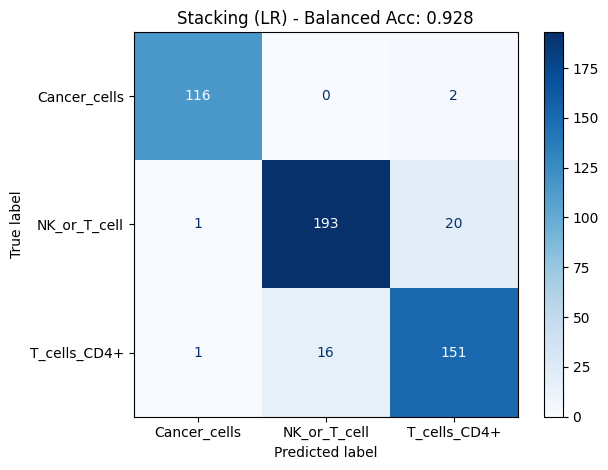

In [30]:
# Filtrage des gènes pour le modèle merged avec threshold=0.2
X_train_merged_filtered, kept_genes_merged_idx = remove_genes(X_train_norm_merged, threshold=1.2)
X_test_merged_filtered = X_test_norm_merged[:, kept_genes_merged_idx]

print(f"Filtered X_train_merged shape: {X_train_merged_filtered.shape}")
print(f"Filtered X_test_merged shape: {X_test_merged_filtered.shape}")

# Entraînement du modèle merged sur les données filtrées
results_merge, pca_model_merge, label_encoder_merge = fit_eval_ensembles(
    X_train_merged_filtered, X_test_merged_filtered, y_train_merged, y_test_merged, pca_n_components=60
)

## Modèle de prediction des classes {"NK_cells", "T_cells_CD8+"}

In [31]:
#reload the data and preprocess
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

#normalize the data

X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

# Create new copies of normalized feature matrices
X_train_norm_binary = X_train_norm.copy()
X_test_norm_binary = X_test_norm.copy()

# Only conserve NK_cells and T_cells_CD8+ in train/test labels
binary_classes = {"NK_cells", "T_cells_CD8+"}

# Convert categorical labels to string arrays
y_train_arr_bin = np.array(y_train).astype(str).copy()
y_test_arr_bin = np.array(y_test).astype(str).copy()

# Filter indices for binary classification
train_idx_bin = np.isin(y_train_arr_bin, list(binary_classes))
test_idx_bin = np.isin(y_test_arr_bin, list(binary_classes))

# Filter features and labels
X_train_norm_bin = X_train_norm_binary[train_idx_bin]
X_test_norm_bin = X_test_norm_binary[test_idx_bin]
y_train_bin = y_train_arr_bin[train_idx_bin]
y_test_bin = y_test_arr_bin[test_idx_bin]

# Convert to pandas Categorical for compatibility
y_train_bin = pd.Categorical(y_train_bin)
y_test_bin = pd.Categorical(y_test_bin)

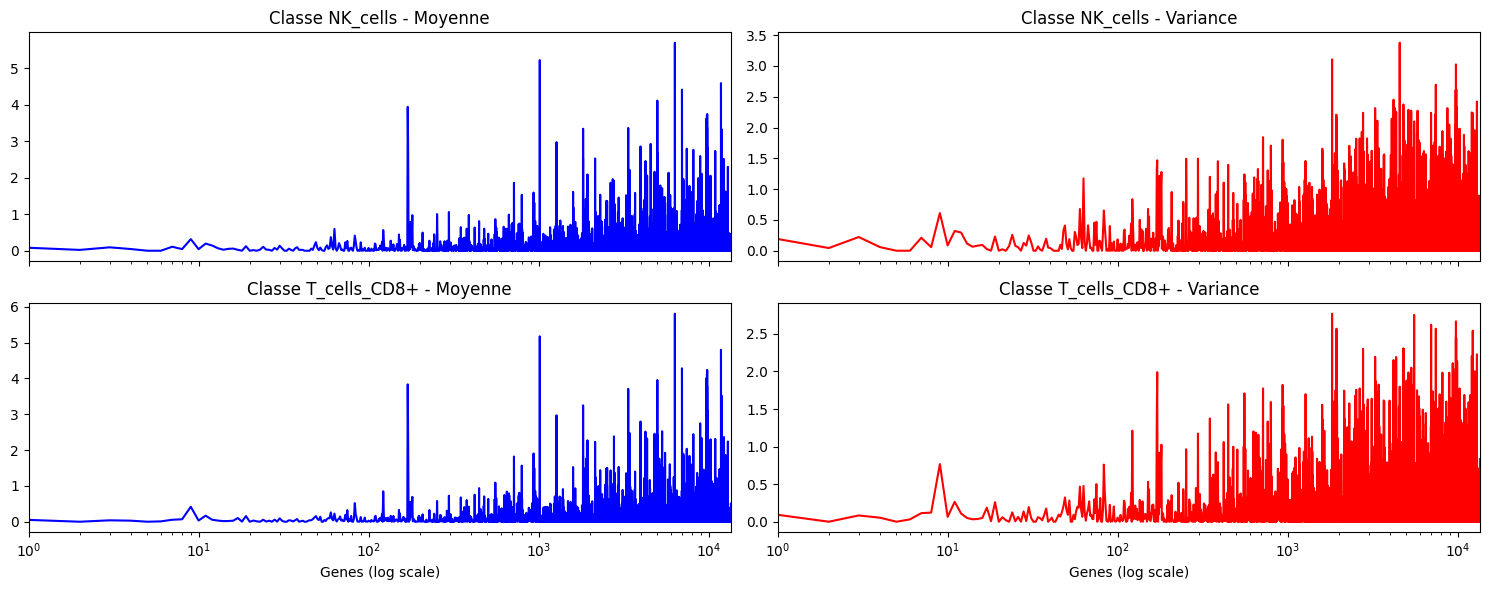

In [32]:


import numpy as np
import matplotlib.pyplot as plt

binary_classes = np.unique(y_train_bin)
n_classes_bin = len(binary_classes)
n_genes_bin = X_train_norm_bin.shape[1]

fig, axes = plt.subplots(n_classes_bin, 2, figsize=(15, 3 * n_classes_bin), sharex=True)

for idx, cls in enumerate(binary_classes):
    gene_values = X_train_norm_bin[np.array(y_train_bin) == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convert sparse -> dense if needed
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes_bin])

    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes_bin])

for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()



We keep only high expressed genes

In [33]:
from scipy.sparse import issparse

# Remove low expressed genes using variance threshold 0.2

X_train_bin_filtered, kept_genes_bin_idx = remove_genes(X_train_norm_bin, threshold=0.8)
X_test_bin_filtered = X_test_norm_bin[:, kept_genes_bin_idx]

print(f"Filtered X_train_bin shape: {X_train_bin_filtered.shape}")
print(f"Filtered X_test_bin shape: {X_test_bin_filtered.shape}")

Filtered X_train_bin shape: (427, 616)
Filtered X_test_bin shape: (214, 616)


Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.837


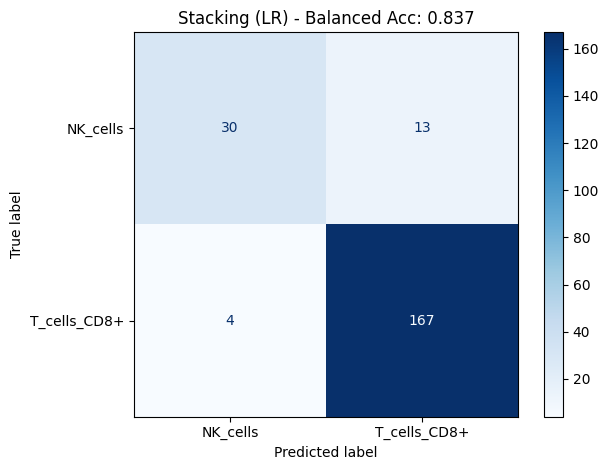

In [34]:

# Train and predict using the previous ensemble function
results_bin, pca_model_bin, label_encoder_bin = fit_eval_ensembles(
    X_train_bin_filtered, X_test_bin_filtered, y_train_bin, y_test_bin, pca_n_components=0.8
)

## Combinaison des deux modèles

## Designing the RAMP submission


In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.sparse import issparse


def remove_genes(X, threshold=0.01):
    """
    Supprime les gènes dont la variance est inférieure à un seuil.

    Args:
        X (np.ndarray ou csr_matrix): matrice cellules x gènes
        threshold (float): seuil minimal de variance

    Returns:
        X_filtered: matrice filtrée (mêmes type que X)
        kept_idx: indices des gènes conservés
    """
    if issparse(X):
        # variance = mean(x^2) - mean(x)^2
        mean = np.array(X.mean(axis=0)).ravel()
        mean_sq = np.array(X.multiply(X).mean(axis=0)).ravel()
        var = mean_sq - mean**2
    else:
        var = X.var(axis=0)

    # indices des gènes à garder
    kept_idx = np.where(var >= threshold)[0]

    # filtrer X
    if issparse(X):
        X_filtered = X[:, kept_idx]
    else:
        X_filtered = X[:, kept_idx]

    return X_filtered, kept_idx


class Classifier(BaseEstimator, ClassifierMixin):
    """
    Two-stage classifier for single-cell RNA-seq data.
    Inherits from BaseEstimator and ClassifierMixin for sklearn compatibility.
    """
    
    def __init__(self,
                 # Stage 1 (Merged model) parameters
                 merge_variance_threshold=1.2,
                 merge_pca_components=60,
                 merge_rf_n_estimators=200,
                 merge_rf_max_depth=50,
                 merge_rf_max_features="sqrt",
                 merge_svc_C=1.0,
                 merge_svc_gamma="scale",
                 merge_svc_kernel="rbf",
                 merge_knn_n_neighbors=15,
                 merge_lr_max_iter=10000,
                 merge_lr_solver="lbfgs",
                 
                 # Stage 2 (Binary model) parameters
                 binary_variance_threshold=0.8,
                 binary_pca_components=0.8,
                 binary_rf_n_estimators=200,
                 binary_rf_max_depth=50,
                 binary_rf_max_features="sqrt",
                 binary_svc_C=1.0,
                 binary_svc_gamma="scale",
                 binary_svc_kernel="rbf",
                 binary_knn_n_neighbors=15,
                 binary_lr_max_iter=10000,
                 binary_lr_solver="lbfgs",
                 
                 # Preprocessing parameters
                 normalization_factor=1e4,
                 
                 # General parameters
                 random_state=42,
                 n_jobs=-1):
        """
        Initialize the two-stage classifier.
        
        All parameters are stored as instance attributes for sklearn compatibility.
        """
        # Stage 1 parameters
        self.merge_variance_threshold = merge_variance_threshold
        self.merge_pca_components = merge_pca_components
        self.merge_rf_n_estimators = merge_rf_n_estimators
        self.merge_rf_max_depth = merge_rf_max_depth
        self.merge_rf_max_features = merge_rf_max_features
        self.merge_svc_C = merge_svc_C
        self.merge_svc_gamma = merge_svc_gamma
        self.merge_svc_kernel = merge_svc_kernel
        self.merge_knn_n_neighbors = merge_knn_n_neighbors
        self.merge_lr_max_iter = merge_lr_max_iter
        self.merge_lr_solver = merge_lr_solver
        
        # Stage 2 parameters
        self.binary_variance_threshold = binary_variance_threshold
        self.binary_pca_components = binary_pca_components
        self.binary_rf_n_estimators = binary_rf_n_estimators
        self.binary_rf_max_depth = binary_rf_max_depth
        self.binary_rf_max_features = binary_rf_max_features
        self.binary_svc_C = binary_svc_C
        self.binary_svc_gamma = binary_svc_gamma
        self.binary_svc_kernel = binary_svc_kernel
        self.binary_knn_n_neighbors = binary_knn_n_neighbors
        self.binary_lr_max_iter = binary_lr_max_iter
        self.binary_lr_solver = binary_lr_solver
        
        # Other parameters
        self.normalization_factor = normalization_factor
        self.random_state = random_state
        self.n_jobs = n_jobs
        
        # These will be set during fit
        self.le_merge = None
        self.le_bin = None
        self.kept_idx_merge = None
        self.kept_idx_bin = None
        self.pipe_merge = None
        self.pipe_bin = None
        self.classes_ = None
        self.class_to_idx = None
        self.merged_label = None

    def _build_models(self):
        """
        Build the pipeline models using current parameters.
        Called at the beginning of fit() to ensure models use latest parameters.
        """
        # Initialize label encoders
        self.le_merge = LabelEncoder()
        self.le_bin = LabelEncoder()
        
        # ===== STAGE 1: Merged Model =====
        rf_merge = RandomForestClassifier(
            n_estimators=self.merge_rf_n_estimators,
            max_depth=self.merge_rf_max_depth,
            max_features=self.merge_rf_max_features,
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )
        
        svc_merge = SVC(
            kernel=self.merge_svc_kernel,
            probability=True,
            C=self.merge_svc_C,
            gamma=self.merge_svc_gamma,
            random_state=self.random_state
        )
        
        knn_merge = KNeighborsClassifier(
            n_neighbors=self.merge_knn_n_neighbors,
            n_jobs=self.n_jobs
        )
        
        stack_merge = StackingClassifier(
            estimators=[("rf", rf_merge), ("svc", svc_merge), ("knn", knn_merge)],
            final_estimator=LogisticRegression(
                max_iter=self.merge_lr_max_iter,
                solver=self.merge_lr_solver,
                random_state=self.random_state
            ),
            n_jobs=self.n_jobs,
            passthrough=False
        )
        
        self.pipe_merge = make_pipeline(
            PCA(n_components=self.merge_pca_components, random_state=self.random_state),
            stack_merge
        )
        
        # ===== STAGE 2: Binary Model =====
        rf_bin = RandomForestClassifier(
            n_estimators=self.binary_rf_n_estimators,
            max_depth=self.binary_rf_max_depth,
            max_features=self.binary_rf_max_features,
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )
        
        svc_bin = SVC(
            kernel=self.binary_svc_kernel,
            probability=True,
            C=self.binary_svc_C,
            gamma=self.binary_svc_gamma,
            random_state=self.random_state
        )
        
        knn_bin = KNeighborsClassifier(
            n_neighbors=self.binary_knn_n_neighbors,
            n_jobs=self.n_jobs
        )
        
        stack_bin = StackingClassifier(
            estimators=[("rf", rf_bin), ("svc", svc_bin), ("knn", knn_bin)],
            final_estimator=LogisticRegression(
                max_iter=self.binary_lr_max_iter,
                solver=self.binary_lr_solver,
                random_state=self.random_state
            ),
            n_jobs=self.n_jobs,
            passthrough=False
        )
        
        self.pipe_bin = make_pipeline(
            PCA(n_components=self.binary_pca_components, random_state=self.random_state),
            stack_bin
        )

    def _preprocess_X(self, X, fit=False, kept_idx=None, threshold=0.01):
        """
        Preprocess features: filter genes + library size normalization + log1p
        """
        # Convert sparse to dense if needed
        if issparse(X):
            X = X.toarray()
        
        # Gene filtering
        if fit:
            X_filtered, kept_idx = remove_genes(X, threshold=threshold)
            return_idx = kept_idx
        else:
            if kept_idx is None:
                raise ValueError("kept_idx must be provided when fit=False")
            X_filtered = X[:, kept_idx]
            return_idx = None
        
        # Library size normalization + log1p
        libsize = X_filtered.sum(axis=1)[:, None]
        libsize[libsize == 0] = 1
        X_processed = np.log1p(X_filtered / libsize * self.normalization_factor)
        
        if fit:
            return X_processed, return_idx
        else:
            return X_processed

    def fit(self, X_sparse, y):
        """
        Train the two-stage classifier
        
        Stage 1: Train merged model (3 classes)
        Stage 2: Train binary model (NK_cells vs T_cells_CD8+)
        """
        # Build models with current parameters
        self._build_models()
        
        # Convert y to numpy array
        y_arr = np.array(y).astype(str)
        
        # ===== STAGE 1: Merged Model (3 classes) =====
        # Merge NK_cells and T_cells_CD8+ into one class
        merge_from = {"NK_cells", "T_cells_CD8+"}
        self.merged_label = "NK_or_T_cell"  # Store the merged label name
        
        y_merged = y_arr.copy()
        y_merged[np.isin(y_merged, list(merge_from))] = self.merged_label
        
        # Preprocess and fit merged model
        X_merge, self.kept_idx_merge = self._preprocess_X(
            X_sparse, fit=True, threshold=self.merge_variance_threshold
        )
        y_merge_enc = self.le_merge.fit_transform(y_merged)
        self.pipe_merge.fit(X_merge, y_merge_enc)
        
        # ===== STAGE 2: Binary Model (NK_cells vs T_cells_CD8+) =====
        # Filter to only NK_cells and T_cells_CD8+
        binary_classes = {"NK_cells", "T_cells_CD8+"}
        bin_mask = np.isin(y_arr, list(binary_classes))
        
        X_bin = X_sparse[bin_mask] if issparse(X_sparse) else X_sparse[bin_mask]
        y_bin = y_arr[bin_mask]
        
        # Preprocess with higher variance threshold for binary model
        X_bin_processed, self.kept_idx_bin = self._preprocess_X(
            X_bin, fit=True, threshold=self.binary_variance_threshold
        )
        y_bin_enc = self.le_bin.fit_transform(y_bin)
        self.pipe_bin.fit(X_bin_processed, y_bin_enc)
        
        # Store original classes for compatibility
        self.classes_ = np.unique(y_arr)
        
        # Create mapping from class names to indices
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes_)}
        
        return self

    def predict_proba(self, X_sparse):
        """
        Two-stage prediction:
        1. Predict with merged model (3 classes)
        2. If predicted as NK_or_T_cell, refine with binary model
        """
        n_samples = X_sparse.shape[0]
        n_classes = len(self.classes_)
        
        # Initialize probability matrix
        proba_final = np.zeros((n_samples, n_classes))
        
        # ===== STAGE 1: Predict with merged model =====
        X_merge = self._preprocess_X(X_sparse, fit=False, kept_idx=self.kept_idx_merge)
        proba_merge = self.pipe_merge.predict_proba(X_merge)
        y_pred_merge_enc = self.pipe_merge.predict(X_merge)
        y_pred_merge = self.le_merge.inverse_transform(y_pred_merge_enc)
        
        # ===== STAGE 2: Process predictions =====
        nk_or_t_mask = y_pred_merge == self.merged_label
        
        # For samples NOT predicted as merged class (B_cells or Monocytes)
        for i in np.where(~nk_or_t_mask)[0]:
            pred_label = y_pred_merge[i]
            class_idx = self.class_to_idx[pred_label]
            # Use probabilities from merged model
            merge_class_idx = self.le_merge.transform([pred_label])[0]
            proba_final[i, class_idx] = proba_merge[i, merge_class_idx]
        
        # For samples predicted as merged class, refine with binary model
        if nk_or_t_mask.sum() > 0:
            # Get samples predicted as merged class
            X_bin = X_sparse[nk_or_t_mask] if issparse(X_sparse) else X_sparse[nk_or_t_mask]
            
            # Preprocess with binary model's gene filtering
            X_bin_processed = self._preprocess_X(X_bin, fit=False, kept_idx=self.kept_idx_bin)
            
            # Predict with binary model
            proba_bin = self.pipe_bin.predict_proba(X_bin_processed)
            
            # Map binary probabilities to final matrix
            bin_classes = self.le_bin.classes_
            nk_or_t_indices = np.where(nk_or_t_mask)[0]
            
            for j, sample_idx in enumerate(nk_or_t_indices):
                for k, bin_class in enumerate(bin_classes):
                    class_idx = self.class_to_idx[bin_class]
                    proba_final[sample_idx, class_idx] = proba_bin[j, k]
        
        return proba_final

    def predict(self, X_sparse):
        """
        Predict class labels
        """
        proba = self.predict_proba(X_sparse)
        y_pred_idx = np.argmax(proba, axis=1)
        return self.classes_[y_pred_idx]
    
    def score(self, X, y):
        """
        Return the mean accuracy on the given test data and labels.
        Required for GridSearchCV.
        """
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

Below is a simplified version of what RAMP does with your submission.

In [36]:
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()
clf = Classifier()
clf.fit(X_train, y_train)
# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

In [37]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.9587611799105606
Test balanced accuracy: 0.8439568899913691


## GridSearch sur le two stage

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# ===== 1. Grid Search Simple =====
param_grid = {
    'merge_variance_threshold': [0.8, 1.0, 1.2, 1.5],
    'merge_pca_components': [50, 60, 80],
    'binary_variance_threshold': [0.6, 0.8, 1.0],
    'binary_pca_components': [0.7, 0.8, 0.9],
}

clf = Classifier(random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Test score:", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END binary_pca_components=0.7, binary_variance_threshold=0.6, merge_pca_components=50, merge_variance_threshold=0.8; total time=  44.0s
[CV] END binary_pca_components=0.7, binary_variance_threshold=0.6, merge_pca_components=50, merge_variance_threshold=1.0; total time=  41.9s
[CV] END binary_pca_components=0.7, binary_variance_threshold=0.6, merge_pca_components=50, merge_variance_threshold=1.0; total time=  42.3s
[CV] END binary_pca_components=0.7, binary_variance_threshold=0.6, merge_pca_components=50, merge_variance_threshold=0.8; total time=  42.9s
[CV] END binary_pca_components=0.7, binary_variance_threshold=0.6, merge_pca_components=50, merge_variance_threshold=0.8; total time=  43.0s
[CV] END binary_pca_components=0.7, binary_variance_threshold=0.6, merge_pca_components=50, merge_variance_threshold=0.8; total time=  44.8s
[CV] END binary_pca_components=0.7, binary_variance_threshold=0.6, merge_pca_components=50,

KeyboardInterrupt: 

In [39]:
# ===== 3. Randomized Search (plus rapide) =====
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
clf = Classifier(random_state=42)
param_distributions = {
    'merge_variance_threshold': uniform(0.5, 2.0),
    'merge_pca_components': [40, 50, 60, 70, 80, 100],
    'merge_rf_n_estimators': randint(100, 400),
    'merge_rf_max_depth': randint(30, 80),
    'merge_svc_C': uniform(0.1, 5.0),
    'merge_knn_n_neighbors': randint(5, 30),
    
    'binary_variance_threshold': uniform(0.4, 1.5),
    'binary_pca_components': uniform(0.6, 0.35),
    'binary_rf_n_estimators': randint(100, 400),
    'binary_rf_max_depth': randint(20, 60),
    'binary_svc_C': uniform(0.1, 3.0),
    'binary_knn_n_neighbors': randint(5, 25),
}

random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_distributions,
    n_iter=50,  # Nombre d'itérations
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# ===== 4. Analyser les résultats =====
import pandas as pd

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

# Top 10 configurations
print("\nTop 10 configurations:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10))

# ===== 5. Utiliser le meilleur modèle =====
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END binary_knn_n_neighbors=11, binary_pca_components=0.8787900454010815, binary_rf_max_depth=34, binary_rf_n_estimators=206, binary_svc_C=2.439073000818308, binary_variance_threshold=1.2952752369197307, merge_knn_n_neighbors=23, merge_pca_components=60, merge_rf_max_depth=40, merge_rf_n_estimators=187, merge_svc_C=1.7685430556951092, merge_variance_threshold=0.7857336358438816; total time=  33.4s
[CV] END binary_knn_n_neighbors=11, binary_pca_components=0.8787900454010815, binary_rf_max_depth=34, binary_rf_n_estimators=206, binary_svc_C=2.439073000818308, binary_variance_threshold=1.2952752369197307, merge_knn_n_neighbors=23, merge_pca_components=60, merge_rf_max_depth=40, merge_rf_n_estimators=187, merge_svc_C=1.7685430556951092, merge_variance_threshold=0.7857336358438816; total time=  33.2s
[CV] END binary_knn_n_neighbors=11, binary_pca_components=0.8787900454010815, binary_rf_max_depth=34, binary_rf_n_estimators=206

NameError: name 'grid_search' is not defined

In reality things are a bit more sophisticated. **Locally**, the RAMP platform averages your classifier preformance over a 5-fold cross-validation scheme implemented for you in the `get_cv` method. The good news is, RAMP automatize everything for you thanks to `ramp-test`. The public train, validation and test performance are shown to you for information. 


<div class="alert alert-block alert-info">
<b>A note on hyper-parameter search</b> RAMP does not perform hyper-parameter tuning, nor grid-search for you. You need to implement this locally, on your own machine, and fix the hyper-parameters by hand in your Classifier class when sending your submission. Another option is to use K-fold cross-validation in the `fit()` method of your classifier, but it could lead to heavy computation times that would delay your research. </a>.
</div> 



### Submitting to RAMP

Before submitting to RAMP, you can test your solution locally to ensure that trivial errors (e.g. typos, path issues, etc.) are resolved. We can test a given submission using the `ramp-test` command that was installed in the virtual environment.  

We'll use the following command:  

`!ramp-test --submission <subm_folder> --quick-test` 

The `!` signals that the command should be run on the command line instead of this notebook.  
`ramp-test` is the command to be executed. It signals ramp to perform a local test. 

`--submission <subm_folder>` specifies which submission to run. You can have multiple potential submissions in the `submissions/` directory; this prevents `ramp` from running all of them (and by default it runs starting_kit).  

In [46]:
!ramp-test --submission test

Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/test ...
CV fold 0
	score  bal_acc       time
	train     0.97  15.539851
	valid     0.87   0.851509
	test      0.83   0.464641
CV fold 1
	score  bal_acc       time
	train     0.98  12.644568
	valid     0.86   0.864656
	test      0.82   0.752410
CV fold 2
	score  bal_acc       time
	train     0.97  12.158776
	valid     0.88   0.850106
	test      0.83   0.722818
CV fold 3
	score  bal_acc       time
	train     0.97  13.343846
	valid     0.89   0.851153
	test      0.84   0.571204
CV fold 4
	score  bal_acc       time
	train     0.98  12.465863
	valid     0.86   0.704855
	test      0.86   0.679383
----------------------------
Mean CV scores
----------------------------
	score       bal_acc         time
	train  0.97 ± 0.006  13.2 ± 1.22
	valid  0.87 ± 0.012   0.8 ± 0.06
	test   0.84 ± 0.011   0.6 ± 0.11
----------------------------
Bagged scores
-------------

We see that the mean CV scores are consistent with the previous result we had. If you use a classifier with more variance, you would see more variation accross CV-folds. 

<div class="alert alert-info"> 
    
<b>Note on style complicance</b> Every `submissions/*.py` files will be checked for style compliance before running on RAMP server. It is done thanks to the [flake8](https://flake8.pycqa.org/en/latest/) package. Before submitting, you need to fix any error raised by the following terminal command
    
`$flake8 submissions/`
<br/>

The **black** auto-formatting tool works very well to automatically format your code accoring to flake8 standard when saving your files in VScode or PyCharm IDEs. 

You might want to check [this page](https://flake8.pycqa.org/en/3.1.1/user/ignoring-errors.html) for ignoring specific errors in some corner-cases. 

</div>

## Ranking & Leaderboard

**On the server**, the participants are ranked according to the balanced accuracy score on the private test data set. However, only the ranking will be available, and not the score in itself in order to avoid overfitting of this private test set. The score on public test will be available as a proxy but your submission could very well have a better ranking on private with a worst balanced accuracy on public. 

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

# Now it's your turn

**Exploration des données**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# Load data
from problem import get_train_data, get_test_data
X_train, Y_train = get_train_data()
X_test, Y_test = get_test_data()

In [ ]:
# Convert to DataFrame
x_train = pd.DataFrame(X_train.toarray())
x_test = pd.DataFrame(X_test.toarray())
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,13541,13542,13543,13544,13545,13546,13547,13548,13549,13550
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
classes = Y_train.categories
print(classes)
annotation ={} 
for i, cls in enumerate(classes):
    annotation[i] = cls
print(annotation)

Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object')
{0: 'Cancer_cells', 1: 'NK_cells', 2: 'T_cells_CD4+', 3: 'T_cells_CD8+'}


0. Cancer_cells
1. NK_cells
2. T_cells_CD4+
3. T_cells_CD8+


In [ ]:
# Annotation des classes
y_train_encoded = Y_train.codes
y_test_encoded = Y_test.codes
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

y_train.head()

0    2
1    2
2    2
3    2
4    3
dtype: int8

{'classes': Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object'), 'occurrences': 3    342
2    336
0    237
1     85
Name: count, dtype: int64}


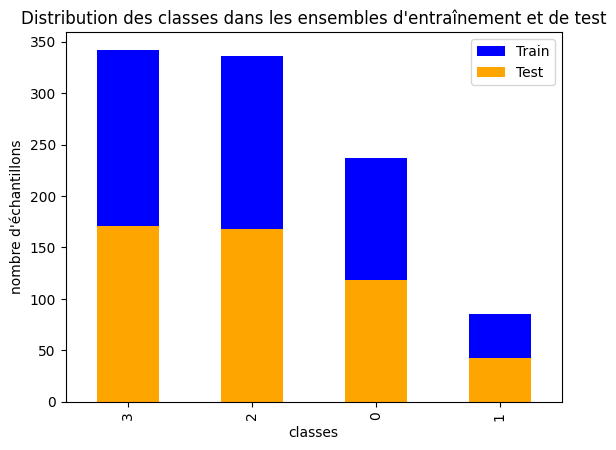

In [ ]:
# Exploration des données

## Distribution des classes 
Occurence_train = {}
Occurence_train["classes"] = classes
Occurence_train["occurrences"] = y_train.value_counts()
print(Occurence_train)

y_train.value_counts().plot(kind='bar', color='blue')
y_test.value_counts().plot(kind='bar', color='orange')
plt.xlabel('classes')
plt.ylabel('nombre d\'échantillons')
plt.title('Distribution des classes dans les ensembles d\'entraînement et de test')
plt.legend(['Train','Test'])


Mon premier essai était d'explorer les données et d'essayer de savoir les gènes importantes pour chaque cellule. Le problème c'est que j'ai fait l'exploration sans normalization et jugé que la moitié des gènes ne sont pas assez représentatives pour la majorité des cellules. Les résultats sont dans les diagrammes au-dessous. 
L'idée derrière est aussi le fait d'ajouter des données pour les la classes 1 en se basant sur la distribution de chaque gène dans les cellules détectées cell_1. 

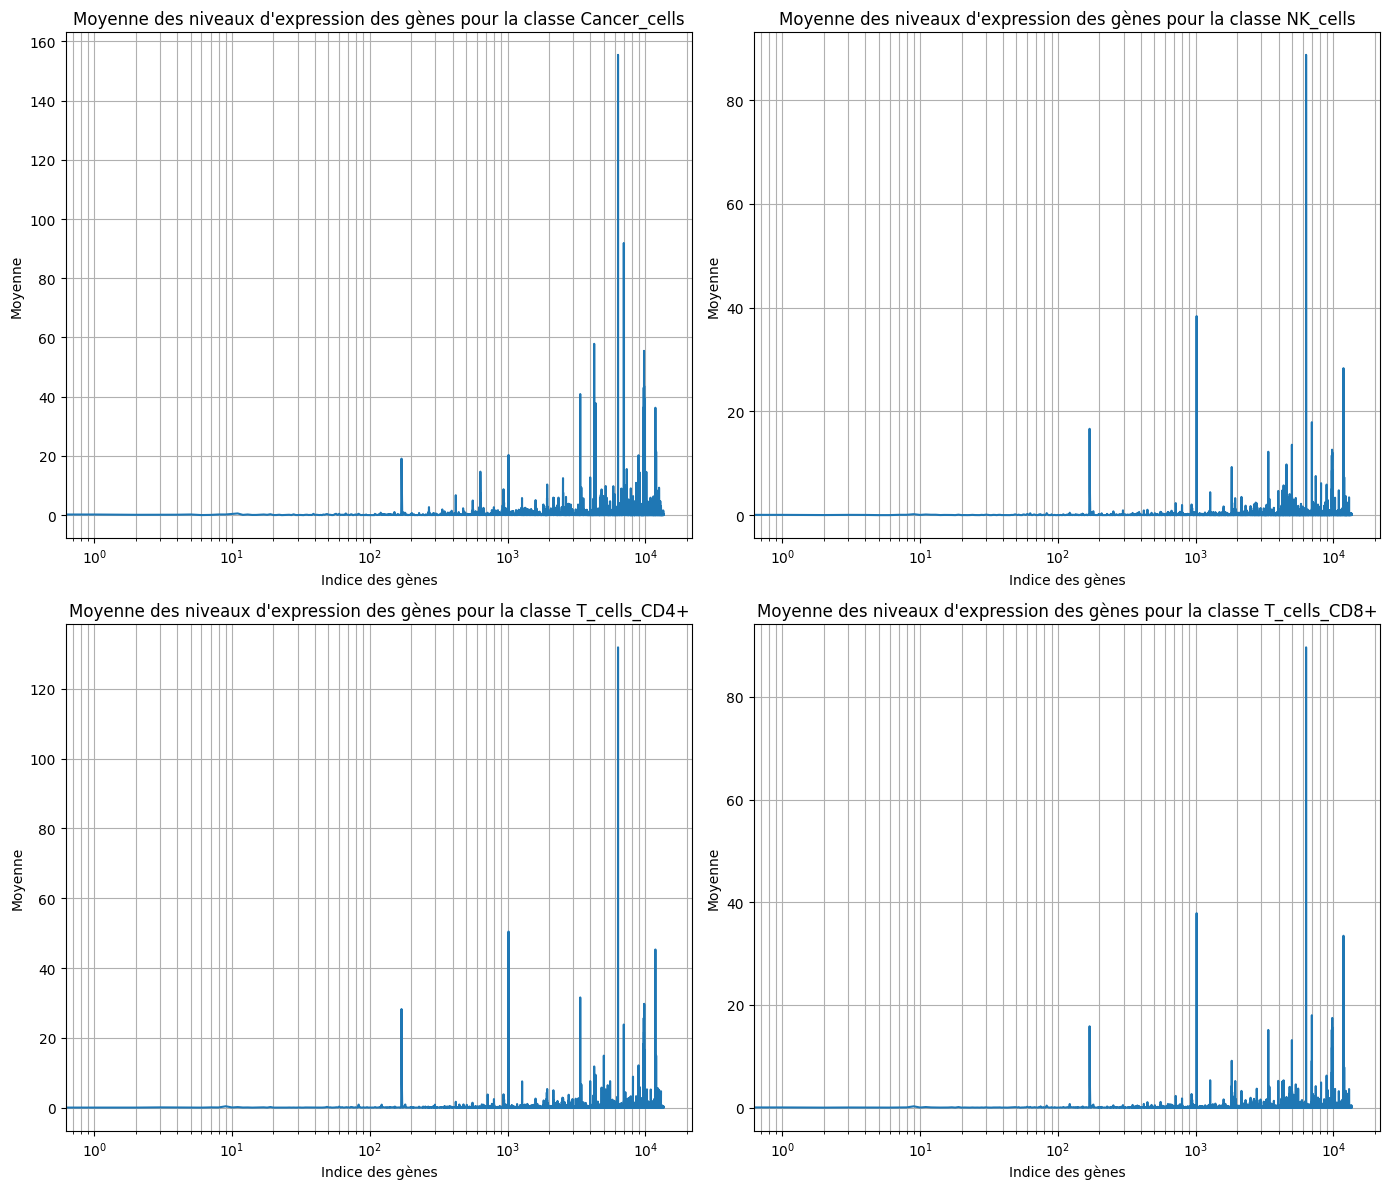

In [ ]:
n_classes = 4
n_cols = 2
n_rows = (n_classes + 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()  

# Répartition des gènes dans les échantillons de toutes les classes
for i in range(n_classes):
    gene_values = x_train[y_train == i]  
    stats = gene_values.describe()       
    mean = stats.loc['mean']             
    
    axes[i].plot(mean.index, mean.values)
    axes[i].set_xscale("log")  
    axes[i].set_title(f'Moyenne des niveaux d\'expression des gènes pour la classe {annotation[i]}')
    axes[i].set_xlabel("Indice des gènes")
    axes[i].set_ylabel("Moyenne")
    axes[i].grid(True, which="both")

# Supprimer les axes vides si besoin
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




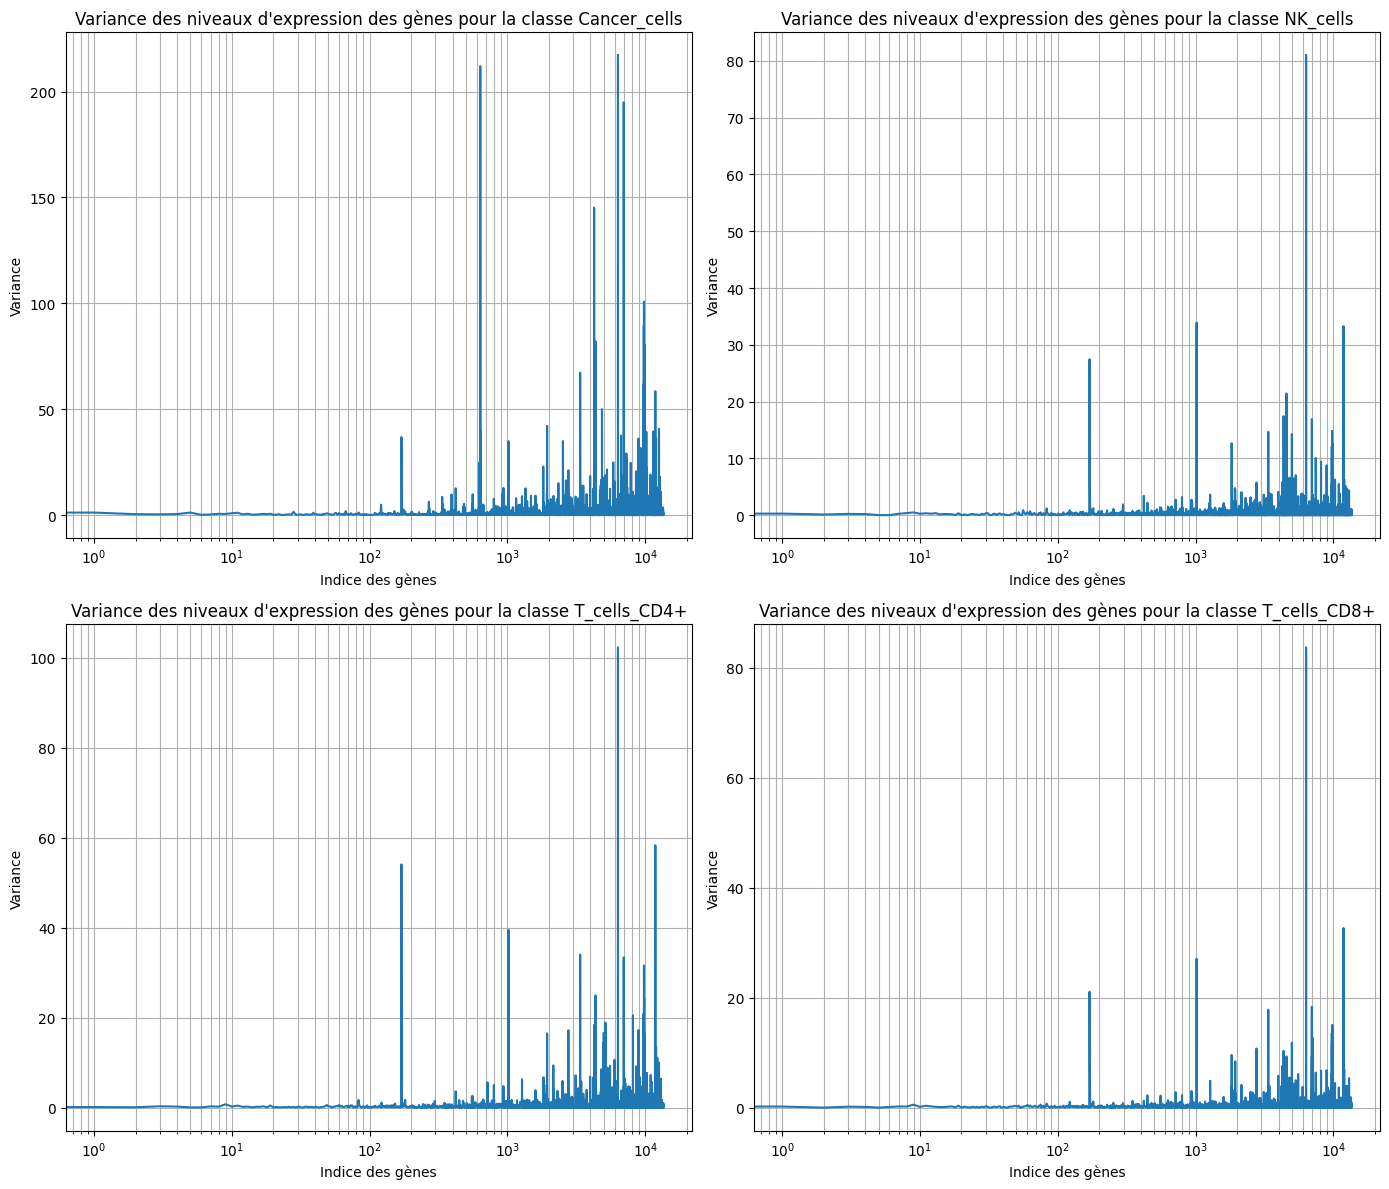

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()  

# Répartition des gènes dans les échantillons de toutes les classes
for i in range(n_classes):
    gene_values = x_train[y_train == i]  
    stats = gene_values.describe()       
    mean = stats.loc['std']             
    
    axes[i].plot(mean.index, mean.values)
    axes[i].set_xscale("log") 
    axes[i].set_title(f'Variance des niveaux d\'expression des gènes pour la classe {annotation[i]}')
    axes[i].set_xlabel("Indice des gènes")
    axes[i].set_ylabel("Variance")
    axes[i].grid(True, which="both")

# Supprimer les axes vides si besoin
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

A partir des digrammes précedants, on remarque qu'environ la moitié  des gènes ( de 0 à 10^2) ne sont pas assez représntatives pour toutes les classes. 
Application de L'ACP pour choisir les features représentatives. 

**Normalisation**
Maintenant je vais essayer de normaliser les données de x_train et les nommer x_train_normalized.

La question qui se pose: pourquoi appliquer une normalisation ? 
 
 - *Correction de la profondeur de séquençage* : Chaque échantillon peut avoir un nombre total de lectures très différent. Sans normalisation, les différences reflètent surtout la quantité totale de séquençage et non l’expression réelle.
 - *Stabilisation de la variance* : Les gènes peu exprimés ont une variance très élevée relative à leur moyenne. Les gènes très exprimés dominent les analyses multivariées (PCA, clustering).
 - *Comparabilité entre échantillons* : Permet de comparer les niveaux d’expression entre échantillons et conditions.

 


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Normalisation CPM
cpm_train = x_train.div(x_train.sum(axis=1), axis=0) * 1e6
cpm_test = x_test.div(x_test.sum(axis=1), axis=0) * 1e6
# Log-transformation
x_train_normalized = np.log2(cpm_train + 1)
x_test_normalized = np.log2(cpm_test + 1)


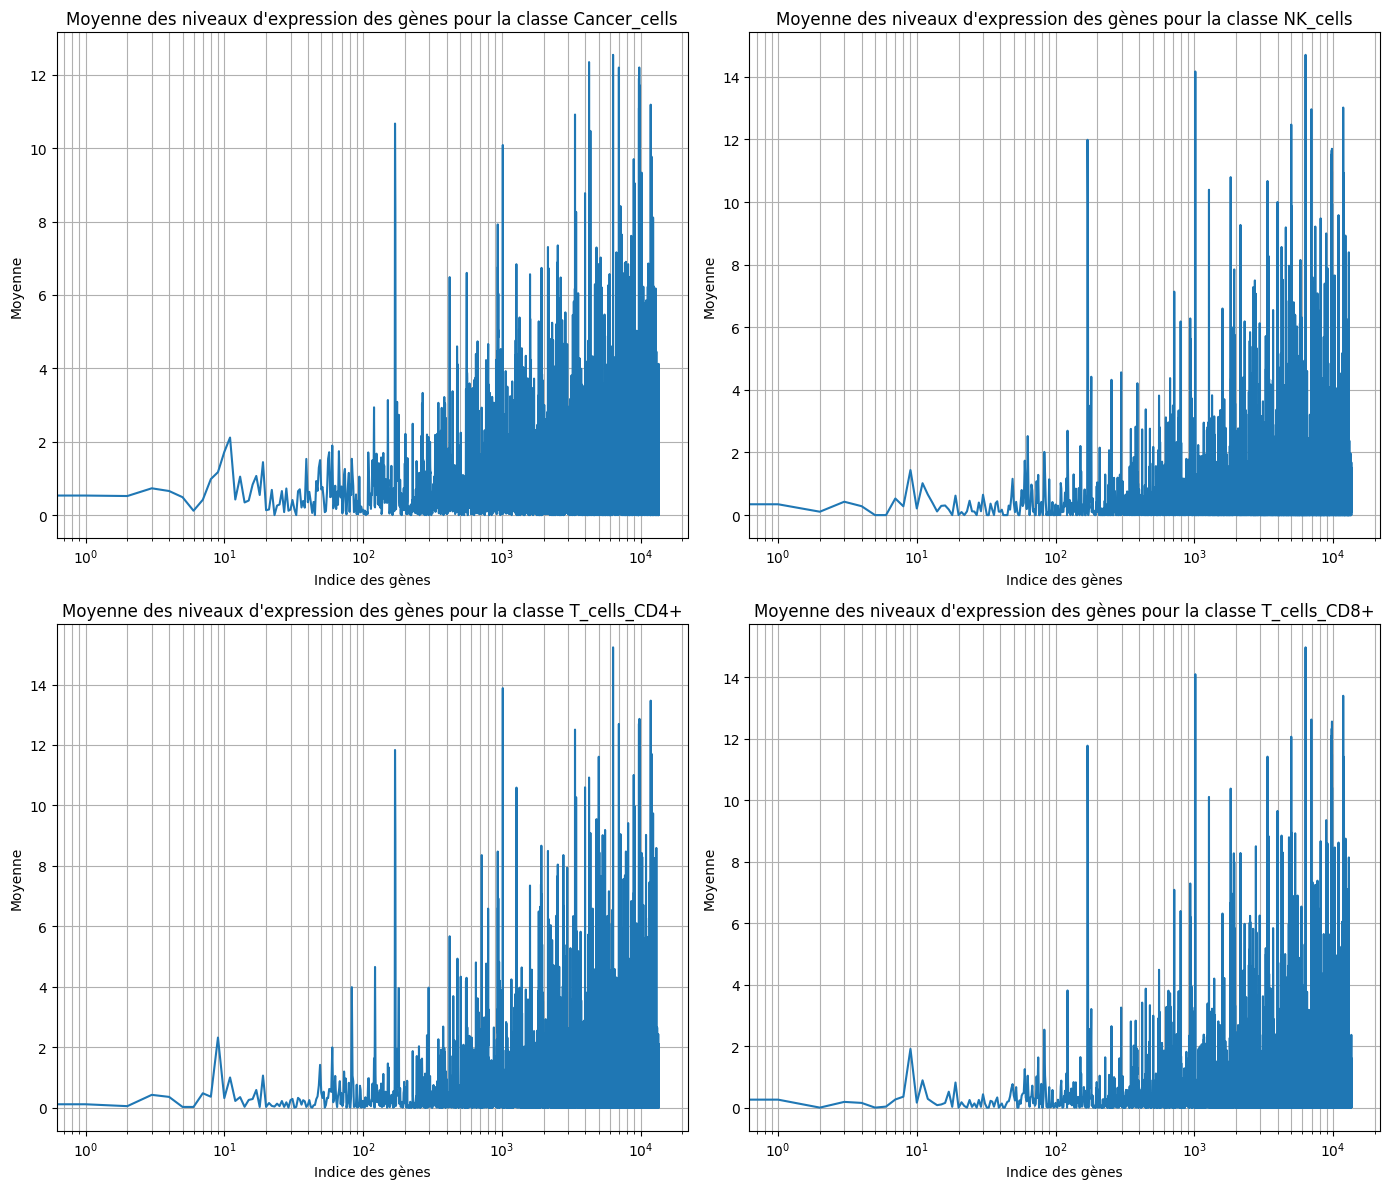

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()  

# Répartition des gènes dans les échantillons de toutes les classes
for i in range(n_classes):
    gene_values = x_train_normalized[y_train == i]  
    stats = gene_values.describe()       
    mean = stats.loc['mean']             
    
    axes[i].plot(mean.index, mean.values)
    axes[i].set_xscale("log")  
    axes[i].set_title(f'Moyenne des niveaux d\'expression des gènes pour la classe {annotation[i]}')
    axes[i].set_xlabel("Indice des gènes")
    axes[i].set_ylabel("Moyenne")
    axes[i].grid(True, which="both")

# Supprimer les axes vides si besoin
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




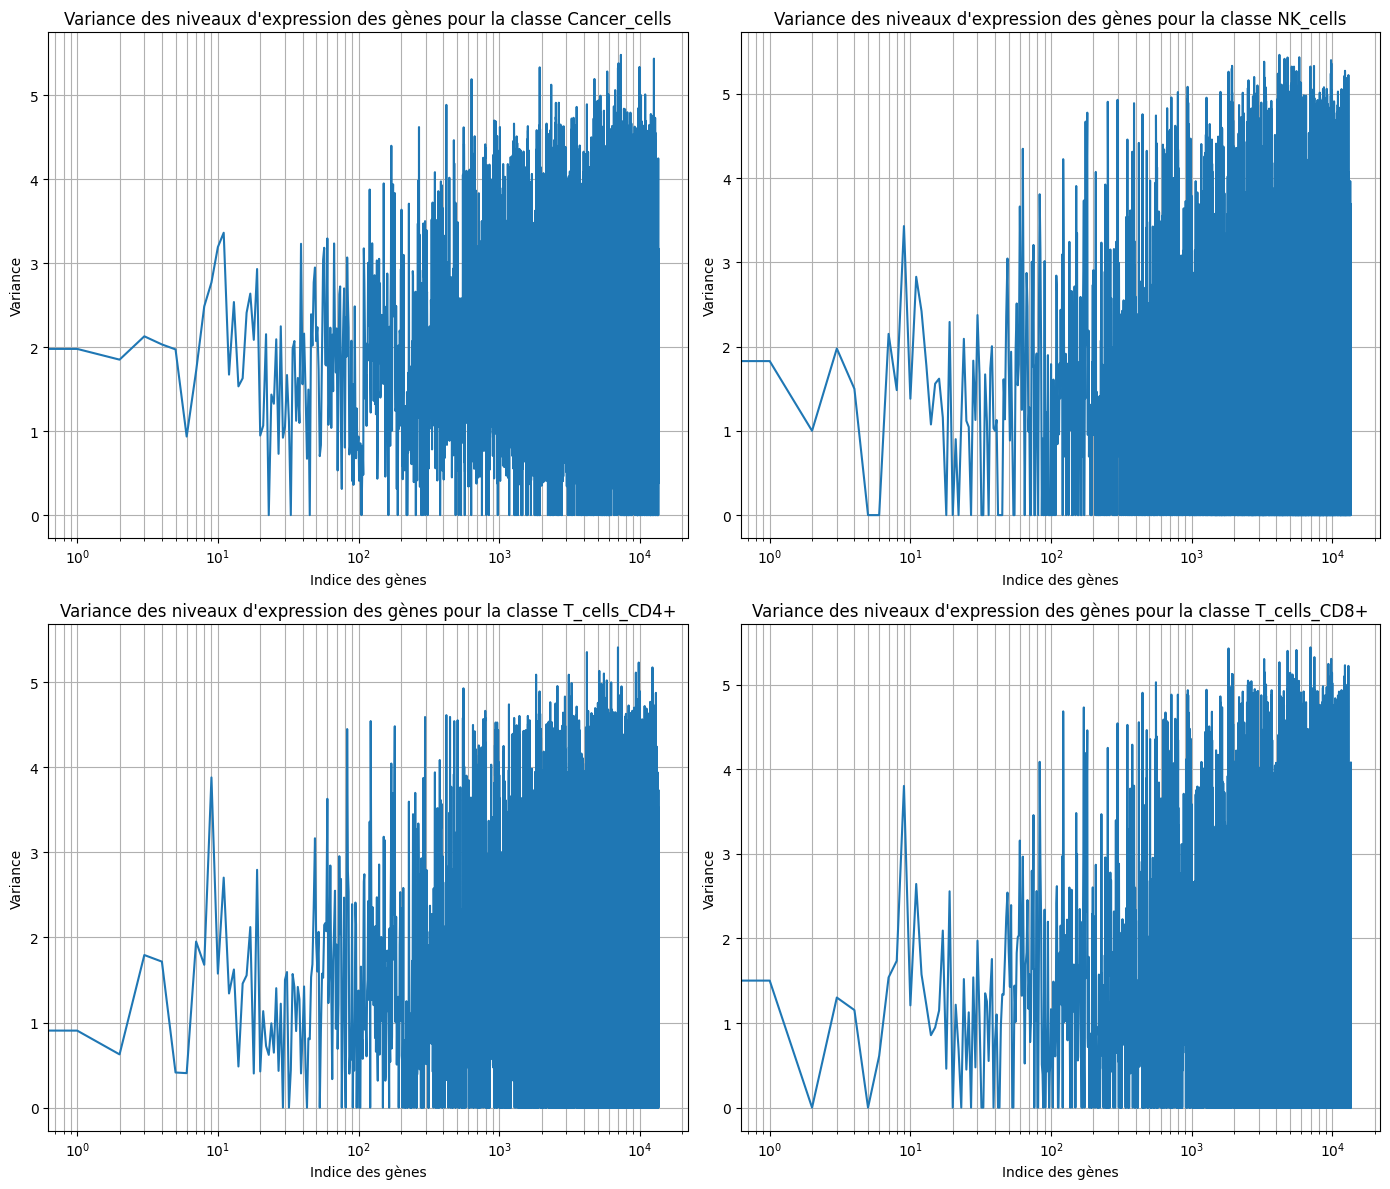

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()  

# Répartition des gènes dans les échantillons de toutes les classes
for i in range(n_classes):
    gene_values = x_train_normalized[y_train == i]  
    stats = gene_values.describe()       
    mean = stats.loc['std']             
    
    axes[i].plot(mean.index, mean.values)
    axes[i].set_xscale("log")  
    axes[i].set_title(f'Variance des niveaux d\'expression des gènes pour la classe {annotation[i]}')
    axes[i].set_xlabel("Indice des gènes")
    axes[i].set_ylabel("Variance")
    axes[i].grid(True, which="both")

# Supprimer les axes vides si besoin
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




**Data Augmentation**



L'objectif de cette partie est de régler le problème des données minoritaires de la cellule 1. 

**Entraînement des modèles** 


In [ ]:
!pip install xgboost

  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.1-py3-none-win_amd64.whl (72.0 MB)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Construction de Piplines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# LASSO Logistic Regression
from sklearn.linear_model import LogisticRegression

pipe_lasso = Pipeline([
    ("Scaler", StandardScaler()),
    ("PCA", PCA(n_components=0.9)),  
    ("LASSO", LogisticRegression(penalty='l1', solver='saga', C=1, max_iter=5000))
])

# SVM avec kernel RBF
from sklearn.svm import SVC

pipe_svm = Pipeline([
    ("Scaler", StandardScaler()),           
    ("PCA", PCA(n_components=0.9)),        
    ("SVM", SVC(kernel="rbf", C=1, gamma='scale'))  
])

# XGBoost Classifier
from xgboost import XGBClassifier
pipe_xgb = Pipeline([
    ("Scaler", StandardScaler()),           
    ("PCA", PCA(n_components=0.9)),       
    ("XGB", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])


# Stacking Classifier with Random Forest

from sklearn.ensemble import RandomForestClassifier, StackingClassifier

pipe_rf = Pipeline([
    ("Scaler", StandardScaler()),
    ("PCA", PCA(n_components=50)),
    ("RF", RandomForestClassifier(max_depth=5, n_estimators=100, max_features=3))
])


stack_pipeline = StackingClassifier(
    estimators=[
        ("SVM", pipe_svm),
        ("LASSO", pipe_lasso),
        ("RF", pipe_rf)
    ],
    final_estimator=LogisticRegression(),  
    passthrough=True,  
    cv=5
)

from lightgbm import LGBMClassifier

pipe_LGBM = Pipeline([
    ("LGBM", LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    objective='multiclass',
    random_state=42,
    n_jobs=-1,
    verbose = -1
))
])



In [ ]:
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from sklearn.model_selection import cross_val_score

**Lasso**

Train balanced accuracy : 1.000
Test balanced accuracy : 0.776


Text(0.5, 1.0, 'Confusion matrix on test set Lasso model')

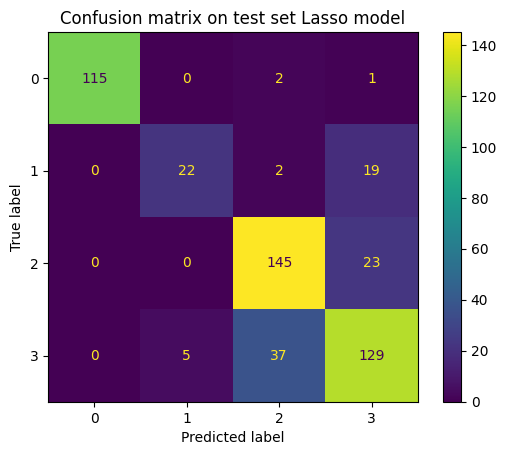

In [ ]:
# fit on train
pipe_lasso.fit(x_train_normalized, y_train)
y_tr_pred = pipe_lasso.predict(x_train_normalized)
# predict on test
y_te_pred = pipe_lasso.predict(x_test_normalized)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_lasso.classes_, )
disp.plot()
plt.title("Confusion matrix on test set Lasso model")

In [ ]:
scores_train = cross_val_score(pipe_lasso, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(pipe_lasso, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold :", scores_train)
print("Accuracy moyenne sur data_train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test :", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

Scores CV pour chaque fold : [0.82  0.83  0.825 0.835 0.845]
Accuracy moyenne sur data_train : 0.8309999999999998
Scores CV pour chaque fold sur data_test : [0.8  0.85 0.77 0.87 0.82]
Accuracy moyenne sur data_test : 0.8220000000000001


**SVM**

Train balanced accuracy : 0.913
Test balanced accuracy : 0.593


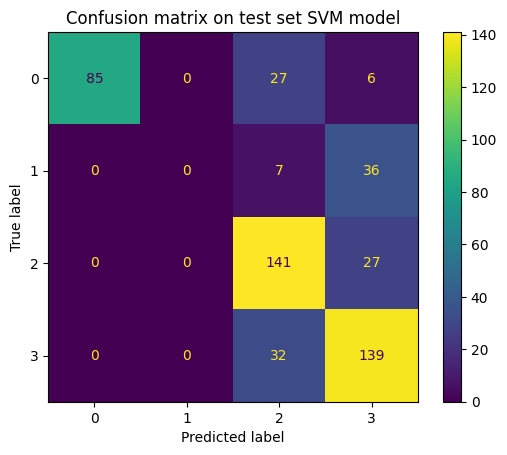

In [ ]:
# fit on train
pipe_svm.fit(x_train_normalized, y_train)
y_tr_pred = pipe_svm.predict(x_train_normalized)
# predict on test
y_te_pred = pipe_svm.predict(x_test_normalized)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_svm.classes_, )
disp.plot()
plt.title("Confusion matrix on test set SVM model");


In [ ]:
scores_train = cross_val_score(pipe_svm, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(pipe_svm, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold sur data_train :", scores_train)
print("Accuracy moyenne sur data_train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test :", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

Scores CV pour chaque fold sur data_train : [0.67  0.69  0.735 0.7   0.735]
Accuracy moyenne sur data_train : 0.706
Scores CV pour chaque fold sur data_test : [0.57 0.59 0.55 0.58 0.61]
Accuracy moyenne sur data_test : 0.58


**XGBoost**

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train balanced accuracy : 1.000
Test balanced accuracy : 0.777


Text(0.5, 1.0, 'Confusion matrix on test set XGboost')

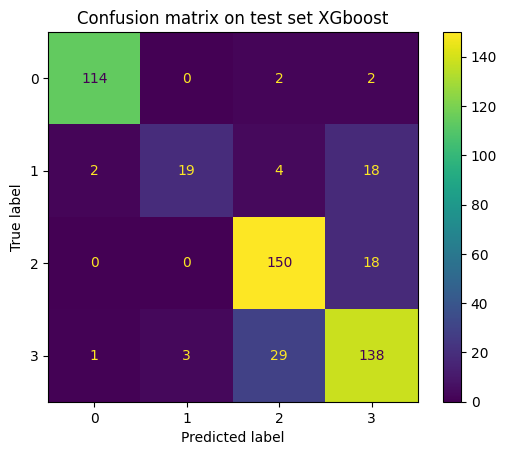

In [ ]:
# fit on train
pipe_xgb.fit(x_train_normalized, y_train)
y_tr_pred = pipe_xgb.predict(x_train_normalized)
# predict on test
y_te_pred = pipe_xgb.predict(x_test_normalized)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_xgb.classes_, )
disp.plot()
plt.title("Confusion matrix on test set XGboost")

In [ ]:
scores_train = cross_val_score(pipe_xgb, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(pipe_xgb, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold sur data_train:", scores_train)
print("Accuracy moyenne sur data train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test:", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

c:\Users\hp\Desktop\Data_Camp\scmark-classification-team_avengers\ramp_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:39:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\Data_Camp\scmark-classification-team_avengers\ramp_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:39:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\Data_Camp\scmark-classification-team_avengers\ramp_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:40:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\Data_Camp\scmark-classification-team_avengers\ramp_env\Lib\

Scores CV pour chaque fold sur data_train: [0.825 0.815 0.82  0.845 0.855]
Accuracy moyenne sur data train : 0.8320000000000001
Scores CV pour chaque fold sur data_test: [0.78 0.82 0.77 0.8  0.74]
Accuracy moyenne sur data_test : 0.782


**Stacking Model**

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train balanced accuracy : 1.000
Test balanced accuracy : 0.778


Text(0.5, 1.0, 'Confusion matrix on test set Stacking model')

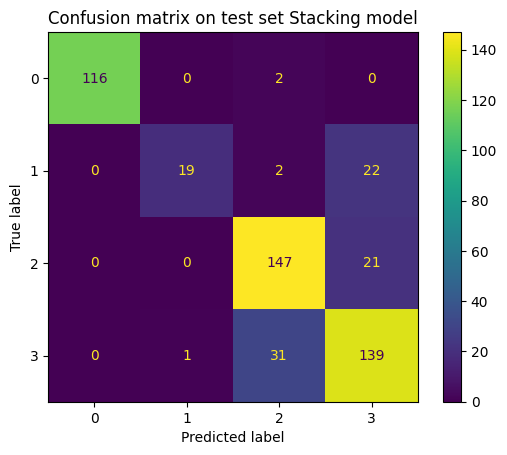

In [ ]:
# fit on train
stack_pipeline.fit(x_train_normalized, y_train)
y_tr_pred = stack_pipeline.predict(x_train_normalized)
# predict on test
y_te_pred = stack_pipeline.predict(x_test_normalized)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack_pipeline.classes_, )
disp.plot()
plt.title("Confusion matrix on test set Stacking model")

In [ ]:
scores_train = cross_val_score(stack_pipeline, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(stack_pipeline, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold sur data_train:", scores_train)
print("Accuracy moyenne sur data train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test:", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

Scores CV pour chaque fold sur data_train: [0.865 0.86  0.865 0.88  0.88 ]
Accuracy moyenne sur data train : 0.8699999999999999
Scores CV pour chaque fold sur data_test: [0.78 0.82 0.8  0.82 0.83]
Accuracy moyenne sur data_test : 0.8099999999999999


**LightXGBM**

In [ ]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


In [ ]:
lgbm = pipe_LGBM.fit(x_train_normalized, y_train)
y_pred_train = lgbm.predict(x_train_normalized)
acc_train = balanced_accuracy_score(y_train, y_pred_train)
print("Accuracy score for train dataset :", acc_train)


y_pred_test = lgbm.predict(x_test_normalized)
acc_test = balanced_accuracy_score(y_test, y_pred_test)
print("Accuracy score for test dataset :", acc_test)

Accuracy score for train dataset : 1.0
Accuracy score for test dataset : 0.8293765429537581


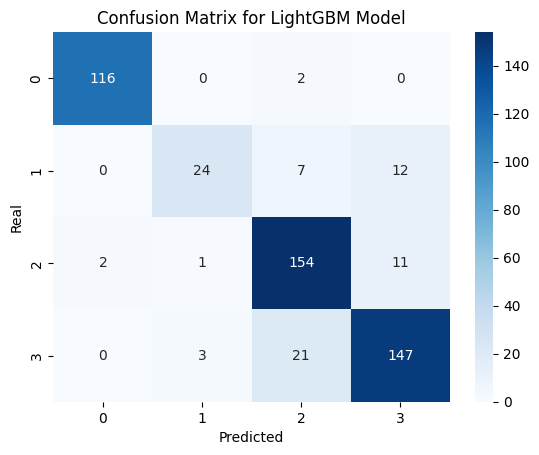

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

In [ ]:
scores_train = cross_val_score(pipe_LGBM, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(pipe_LGBM, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold sur data_train:", scores_train)
print("Accuracy moyenne sur data train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test:", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

Scores CV pour chaque fold sur data_train: [0.86  0.9   0.875 0.905 0.89 ]
Accuracy moyenne sur data train : 0.8859999999999999
Scores CV pour chaque fold sur data_test: [0.84 0.87 0.8  0.87 0.85]
Accuracy moyenne sur data_test : 0.8459999999999999
